# Density Estimator for scRNA-seq Data

This notebook provides a guide to applying the Mellon density estimator on single-cell RNA sequencing (scRNA-seq) data. The objective of this tutorial is to illustrate the steps needed to execute a density estimation using the Mellon package. By the end of this notebook, you should have a solid understanding of how to use Mellon in your data analysis.

Before we start, let's load all the necessary libraries.

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import k_means
import palantir
import mellon
import scanpy as sc

import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

We are also setting some plot preferences and suppressing the NumbaDeprecationWarning for a cleaner output.

In [2]:
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = [4, 4]
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["image.cmap"] = "Spectral_r"
# no bounding boxes or axis:
matplotlib.rcParams["axes.spines.bottom"] = "off"
matplotlib.rcParams["axes.spines.top"] = "off"
matplotlib.rcParams["axes.spines.left"] = "off"
matplotlib.rcParams["axes.spines.right"] = "off"

## Step 1: Loading the Data

We will start by loading the scRNA-seq dataset. For this demonstration, we will use a publicly available dataset of T-cell depleted bone marrow.

In [3]:
ad_url = "https://zenodo.org/record/6383269/files/bm_multiome_rna.h5ad"
ad = sc.read("data/bm_multiome_rna.h5ad", backup_url=ad_url)

Note: The annData object `ad` we loaded already has been processed from raw gene counts according to the following [notebook](https://github.com/settylab/single-cell-primers/blob/main/notebooks/PBMC-RNA-standalone.ipynb), and comes with cell-type annotations, PCA, and a UMAP representation.

## Step 2: Preprocessing

Even though our data is preprocessed, we will further use a diffusion map representation to clean up the cell-state representation. The diffusion map captures the intrinsic geometry of the data by creating a reduced dimensional representation that maintains the relationships between cells.

In [4]:
dm_res = palantir.utils.run_diffusion_maps(ad)

Determing nearest neighbor graph...


## Step 3: Density Calculation

In this step, we leverage Mellon's
[DensityEstimator](https://mellon.readthedocs.io/en/latest/model.html#mellon.model.DensityEstimator)
class to compute the cell density. Post-calculation, we will employ UMAP to visualize the resultant
`log_density`. Notably, we will be producing a clipped version of density. This procedure, which
trims the very low density of outlier cells to the lower 5% percentile, often discloses additional
details in the UMAP representation.

In [5]:
%%time
model = mellon.DensityEstimator()
log_density = model.fit_predict(ad.obsm["DM_EigenVectors"])

predictor = model.predict

ad.obs["log_density"] = log_density
ad.obs["log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)

[2023-06-23 16:34:19,648] [INFO    ] Computing nearest neighbor distances.
[2023-06-23 16:34:19,940] [INFO    ] Using covariance function Matern52(ls=0.0022644533940551514).
[2023-06-23 16:34:19,942] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2023-06-23 16:34:22,342] [INFO    ] Doing low-rank Cholesky decomposition for 7,439 samples and 5,000 landmarks.
[2023-06-23 16:34:27,191] [INFO    ] Using rank 5,000 covariance representation.
[2023-06-23 16:34:28,179] [INFO    ] Running inference using L-BFGS-B.
[2023-06-23 16:34:38,282] [INFO    ] Computing predictive function.
CPU times: user 38.8 s, sys: 48.8 s, total: 1min 27s
Wall time: 20.4 s


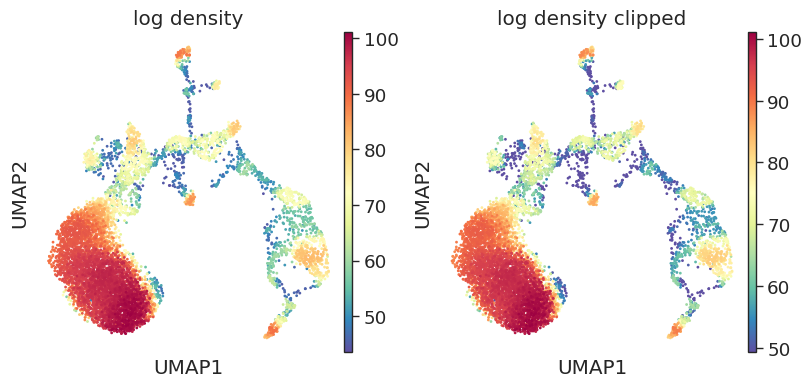

In [6]:
sc.pl.scatter(ad, color=["log_density", "log_density_clipped"], basis="umap")

## Step 4: Analysis

Next, we can use the calculated cell densities to analyze different cell types in the dataset.

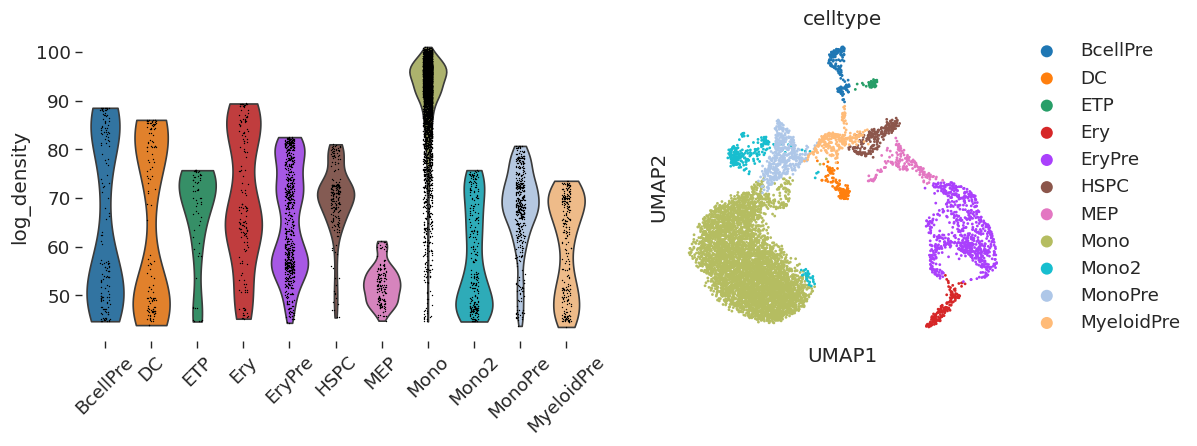

In [7]:
matplotlib.rcParams["figure.figsize"] = [12, 4]
fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[3, 2])
sc.pl.violin(ad, "log_density", "celltype", rotation=45, ax=ax1, show=False)
sc.pl.scatter(ad, color="celltype", basis="umap", ax=ax2, show=False)
plt.show()

## Step 5: Saving and Loading the PredictorSaving and Loading the Predictor

The predictor can be serialized to a dictionary and saved directly within the Anndata object. We can then write the Anndata object to disk, reload it, reconstitute the predictor from the saved dictionary, and apply it to our data. The final check verifies that the deserialized density function is identical to the original.

In [8]:
# Convert to dictionary and save to Anndata, then write Anndata to disk
ad.uns["log_density_function"] = predictor.to_dict()
ad.write("adata.h5ad")

# Reload Anndata and reconstitute predictor
ad = sc.read("adata.h5ad")
predictor = mellon.Predictor.from_dict(ad.uns["log_density_function"])

# Apply loaded predictor and verify it's identical to original
log_density = predictor(ad.obsm["DM_EigenVectors"])
assert np.all(np.isclose(log_density, ad.obs["log_density"])), "Deserialized density function differs from original."

Alternatively, you can directly serialize the predictor to disk, bypassing the Anndata step.

In [9]:
# Serialize the predictor to a JSON file
predictor.to_json("density_predictor.json")

# Load the predictor from the JSON file
loaded_predictor = mellon.Predictor.from_json("density_predictor.json")

# Apply the loaded predictor on any data
log_density = loaded_predictor(ad.obsm["DM_EigenVectors"])

[2023-06-23 16:34:49,573] [INFO    ] Written predictor to density_predictor.json.


# Advanced Applications

Mellon offers access to all its intermediate results, giving you the flexibility to supply your own versions. For example, you can provide specific landmark cell states or parameters, opt out from relying on the built-in heuristics, or employ your preferred optimizer. Even custom Bayesian inference schemes can be used on the log-posterior probability for the final inference.

## Tunable Parameters

Mellon's architecture facilitates a customizable approach to cell density computation, providing numerous tunable parameters for model refinement. This adaptability allows you to tailor the model to the unique demands of your dataset. In the following section, we will explore some of these parameters in greater detail.

In [10]:
X = ad.obsm["DM_EigenVectors"]
nn_distances = mellon.parameters.compute_nn_distances(X)

The `length_scale` parameter determines the smoothness of the resulting density function. A lower value leads to a more detailed, but less stable, density function. By default, Mellon calculates the length scale based on a heuristic to maximize the posterior likelihood of the resulting density function.

In [11]:
length_scale = mellon.parameters.compute_ls(nn_distances)

Landmarks in the data are used to approximate the covariance structure and hence the similarity of density values between cells by using the similarity to the landmarks as proxy. K-means clustering centroids usually provide good landmarks. The number of landmarks limits the rank of the covariance matrix.

In [12]:
%%time
n_landmarks = 5000
landmarks = k_means(X, n_landmarks, n_init=1)[0]

CPU times: user 10.5 s, sys: 29.1 s, total: 39.6 s
Wall time: 2.41 s


You can further reduce the rank of the covariance matrix using an improved Nyström approximation. The `rank` parameter allows you to set either the fraction of total variance (sum of eigenvalues) preserved or a specific number of ranks.

In [13]:
%%time
rank = 0.999
cov_func = mellon.cov.Matern52(length_scale)
L = mellon.parameters.compute_L(X, cov_func, landmarks=landmarks, rank=rank)

[2023-06-23 16:34:54,320] [INFO    ] Doing low-rank improved Nyström decomposition for 7,439 samples and 5,000 landmarks.
[2023-06-23 16:35:11,037] [INFO    ] Recovering 99.900182% variance in eigendecomposition.
CPU times: user 2min 53s, sys: 1min 9s, total: 4min 2s
Wall time: 17.3 s


The `d` parameter denotes the dimensionality of the local variation in cell states and by default we assume that the data can vary along all its dimensions. However, if it is known that locally cells vary only along a subspace, e.g., tangential to the phenotypic manifold, then the dimensionality of this subspace should be used. d is used to correctly related the nearest-neighbor-distance distribution to the cell-state density.

In [14]:
d = X.shape[1]

Mellon can automatically suggest a mean value mu for the Gaussian process of log-density to ensure scale invariance. A low value ensures that the density drops of quickly away from the data.

In [15]:
mu = mellon.parameters.compute_mu(nn_distances, d)

An initial value, based on ridge regression, is used by default to speed up the optimization.

In [16]:
%%time
initial_parameters = mellon.parameters.compute_initial_value(nn_distances, d, mu, L)

model = mellon.DensityEstimator(
    nn_distances=nn_distances,
    d=d,
    mu=mu,
    cov_func=cov_func,
    L=L,
    initial_value=initial_parameters,
)

log_density = model.fit_predict(X)

[2023-06-23 16:35:11,824] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2023-06-23 16:35:14,155] [INFO    ] Running inference using L-BFGS-B.
CPU times: user 15.8 s, sys: 29.6 s, total: 45.4 s
Wall time: 7.82 s


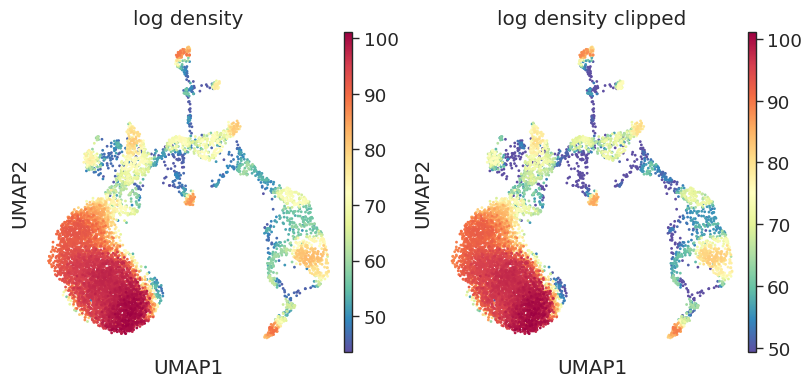

In [17]:
matplotlib.rcParams["figure.figsize"] = [4, 4]
ad.obs["log_density"] = log_density
ad.obs["log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)
sc.pl.scatter(ad, color=["log_density", "log_density_clipped"], basis="umap")

## Stages API

Instead of fitting the model with the fit function, you may split training into
three stages: prepare_inference, run_inference, and process_inference.

In [18]:
model = mellon.DensityEstimator()
model.prepare_inference(X)
model.run_inference()
log_density_x = model.process_inference()

[2023-06-23 16:35:19,672] [INFO    ] Computing nearest neighbor distances.
[2023-06-23 16:35:19,724] [INFO    ] Using covariance function Matern52(ls=0.0022644533940551514).
[2023-06-23 16:35:19,726] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2023-06-23 16:35:22,157] [INFO    ] Doing low-rank Cholesky decomposition for 7,439 samples and 5,000 landmarks.
[2023-06-23 16:35:25,973] [INFO    ] Using rank 5,000 covariance representation.
[2023-06-23 16:35:26,925] [INFO    ] Running inference using L-BFGS-B.
[2023-06-23 16:35:39,131] [INFO    ] Computing predictive function.


This offers the flexibility to make interim modifications. For instance, should you wish to utilize your own optimizer, you can replace `run_inference` with it, using the I/O from the three stages as follows:

```python
def optimize(loss_func, initial_parameters):
    ...
    return optimal_parameters

model = mellon.DensityEstimator()
loss_func, initial_parameters = model.prepare_inference(X)
pre_transformation = optimize(loss_func, initial_parameters)
log_density_x = model.process_inference(pre_transformation=pre_transformation)
```

Note that `loss_func` represents the negative log posterior likelihood of the latent density function representation. Hence, it can be incorporated into custom Bayesian inference schemes aiming to infer a posterior distribution of density functions, including the uncertainty of their values.

## Derivatives

After inference the density and its derivatives can be computed for arbitrary cell-states.

In [19]:
%%time
gradients = predictor.gradient(X)
hessians = predictor.hessian(X)

CPU times: user 8.34 s, sys: 6.08 s, total: 14.4 s
Wall time: 1.72 s
